# Load Results

In [1]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from bs4 import BeautifulSoup
from pandarallel import pandarallel
from torchmetrics.text import EditDistance
from niteru import style_similarity, structural_similarity


os.chdir('..')
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
results = pd.read_json('data/evaluation/results.jsonl', lines=True)
results['model_name'] = results['model_name'] + results['adapter'].apply(lambda x: '' if x is None else f'_{x}')
# Filter models of interest
results = results[results['model_name'].str.contains('ibm') | results['model_name'].str.contains('meta')]
results.head()

,inference_id,dataset,imgid,html,model_name,adapter,model_prediction,model_backend,execution_time
0,dfdb4bf68e324ded1f4c4aeadf548e08,apoidea/pubtabnet-html,613565,"<html>\n <head>\n <meta charset=""utf-8""/>\n ...",ibm-granite/granite-vision-3.2-2b,None,Controls,NVIDIA GeForce RTX 4070 Ti SUPER,0.438457
1,25936d61cb14713bfebc0e7133d721a7,apoidea/pubtabnet-html,592865,"<html>\n <head>\n <meta charset=""utf-8""/>\n ...",ibm-granite/granite-vision-3.2-2b,None,<tr><td>Exposure time per week</td><td>People ...,NVIDIA GeForce RTX 4070 Ti SUPER,5.807385
2,bdf395103cc360c3d4a02cb59fdb6f49,apoidea/pubtabnet-html,616588,"<html>\n <head>\n <meta charset=""utf-8""/>\n ...",ibm-granite/granite-vision-3.2-2b,None,"<thead><tr><td></td><td colspan=""4"">Clinical C...",NVIDIA GeForce RTX 4070 Ti SUPER,9.369443
3,4fed1a9b04f13e0f7af6dc432f45a3af,apoidea/pubtabnet-html,634629,"<html>\n <head>\n <meta charset=""utf-8""/>\n ...",ibm-granite/granite-vision-3.2-2b,None,<tr><td>taxonomic group</td><td>txid</td><td>#...,NVIDIA GeForce RTX 4070 Ti SUPER,7.052494
4,090635df8ad28dc4384b83c652c23304,apoidea/pubtabnet-html,689997,"<html>\n <head>\n <meta charset=""utf-8""/>\n ...",ibm-granite/granite-vision-3.2-2b,None,"<thead><tr><td rowspan=""2"">Registration period...",NVIDIA GeForce RTX 4070 Ti SUPER,7.188730


# Define Metrics

In [3]:
ed_distance = EditDistance()

def extract_table_text(html):
    """Extracts only the text from an HTML table in row-wise space-separated format."""
    soup = BeautifulSoup(html, "html.parser")
    table = soup.find("table")  # Find the first table
    if not table:
        return ""

    # Extract rows and join cells with spaces
    return "\n".join(" ".join(cell.get_text(strip=True) for cell in row.find_all(["th", "td"])) for row in table.find_all("tr"))

def extract_html_table(html):
    """Extracts html table from text"""
    match = re.search(r'<table\b.*?</table>', html, re.DOTALL | re.IGNORECASE)
    if match:
        table_html = match.group()
        return table_html
    else:
        return html

def html_similarity(html1, html2):
    html1 = extract_html_table(html1)
    html2 = extract_html_table(html2)
    # Compute individual similarity scores
    style_sim = style_similarity(html1, html2)  # Assume returns [0,1]
    struct_sim = structural_similarity(html1, html2)  # Assume returns [0,1]
    txt1, txt2 = extract_table_text(html1), extract_table_text(html2)
    content_sim = 1 - (ed_distance(txt1, txt2) /
                                   max(len(txt1), len(txt2) + 1e-10))  # Avoid division by zero
    jaccard_sim = 1 - (len(set(txt1.split()).intersection(set(txt2.split()))) /
                        len(set(txt1.split()).union(set(txt2.split()))) + 1e-10)
    
    # Weighted sum of the similarities
    final_score = (0.10 * style_sim) + (0.40 * struct_sim) + (0.30 * content_sim) + (0.20 * jaccard_sim)

    # Ensure final score is in [0,1]
    final_score = max(0, min(1, final_score))

    return final_score

# Apply Metrics

In [4]:
results['html_similarity'] = results.parallel_apply(
    lambda x: html_similarity(x['html'], x['model_prediction']),
    axis=1
)

# Plot html similarity per model_name

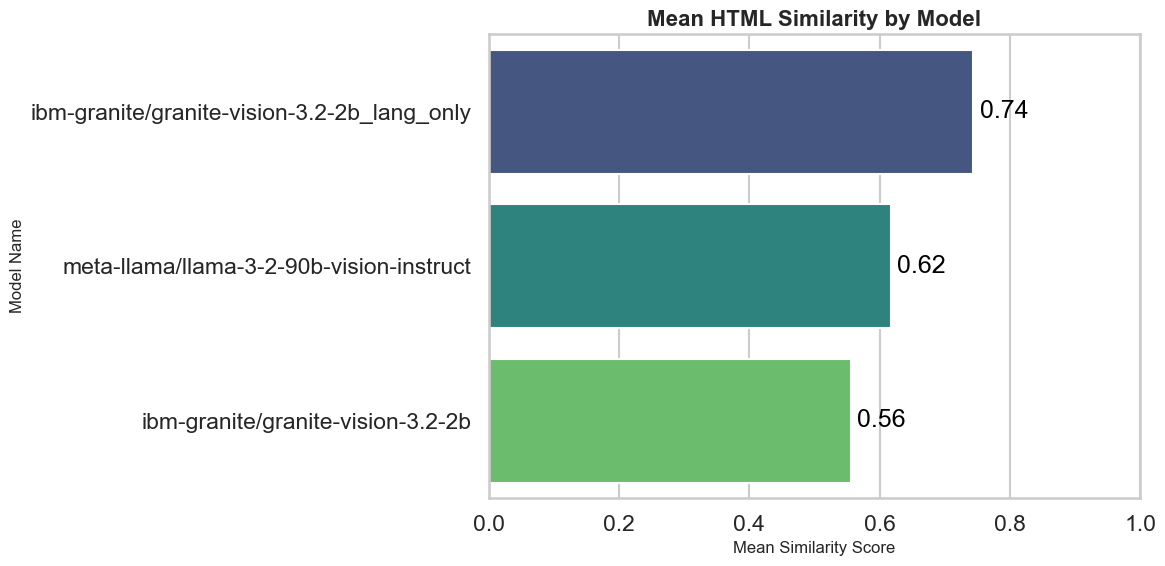

In [5]:
# Prepare and sort data
mean_sim = (
    results[['model_name', 'html_similarity']]
    .groupby('model_name')
    .mean()
    .reset_index()
    .sort_values('html_similarity', ascending=False)
)

# Set style
sns.set(style="whitegrid", context="talk")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x='html_similarity',
    y='model_name',
    hue='model_name',            # Assign hue to enable palette
    data=mean_sim,
    palette='viridis',
    dodge=False,
    legend=False                 # Disable redundant legend
)

# Labels and formatting
plt.title('Mean HTML Similarity by Model', fontsize=16, weight='bold')
plt.xlabel('Mean Similarity Score', fontsize=12)
plt.ylabel('Model Name', fontsize=12)
plt.xlim(0, 1)
plt.tight_layout()

# Add value labels
for i, v in enumerate(mean_sim['html_similarity']):
    plt.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')

plt.show()